In [1]:
import tensorflow as tf
import numpy as np

In [2]:
import utils

In [3]:
SAMPLING_RATE = 6
SEQUENCE_LENGTH = 120
DELAY = SAMPLING_RATE * (SEQUENCE_LENGTH + 24 - 1)
BATCH_SIZE = 256

In [4]:
temperature, raw_data = utils.load_data()
num_train_samples = int(0.5 * len(raw_data))


In [5]:
normalized_data, mean, std = utils.normalize_data(raw_data, num_train_samples)


In [6]:
train_dataset, val_dataset, test_dataset = utils.split_data_keras(normalized_data, temperature, sampling_rate = 6, sequence_length=120, batch_size=256)

2022-06-08 22:34:01.093062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 22:34:01.117951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 22:34:01.118104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 22:34:01.118692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Notes:
- raw_data -= mean doesn't seem to work?
- why does evaluate_naive_method doesn't give the correct numbers (around 2.9)?

In [7]:
utils.evaluate_naive_method(val_dataset, mean=mean, std=std)

2.442540749679173

In [8]:
utils.evaluate_naive_method(test_dataset, mean=mean, std=std)

2.6207366601649253

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
# keras.mixed_precision.set_global_policy("mixed_float16")

In [10]:
inputs = keras.Input(shape=(SEQUENCE_LENGTH, raw_data.shape[-1]))
x = layers.SeparableConv1D(16, 24, activation="relu", padding="same")(inputs)
# x = layers.Dropout(0.5)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.LayerNormalization()(x)
x = layers.SeparableConv1D(32, 12, activation="relu", padding="same")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.LayerNormalization()(x)
x = layers.SeparableConv1D(64, 6, activation="relu", padding="same")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [11]:
def smape(y_true, y_pred):
    raw = tf.math.reduce_mean(tf.math.abs(y_true - y_pred) / (tf.math.abs(y_true) + tf.math.abs(y_pred)))
    return 100*(1-raw)

In [13]:
model.compile(optimizer="adam", loss="mse", metrics=["mae", smape])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 separable_conv1d (Separable  (None, 120, 16)          576       
 Conv1D)                                                         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 16)           0         
 )                                                               
                                                                 
 layer_normalization (LayerN  (None, 60, 16)           32        
 ormalization)                                                   
                                                                 
 separable_conv1d_1 (Separab  (None, 60, 32)           736       
 leConv1D)                                                   

In [34]:
callbacks = [keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True, monitor="val_mae", mode="min",custom_objects=smape)]
history = model.fit(
    train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 8s 9ms/step - loss: 24.2865 - mae: 3.6012 - smape: 69.7476 - val_loss: 12.3399 - val_mae: 2.7702 - val_smape: 76.5034
Epoch 2/10
819/819 [==============================] - 7s 9ms/step - loss: 11.0063 - mae: 2.6056 - smape: 76.6469 - val_loss: 11.5642 - val_mae: 2.6717 - val_smape: 76.6950
Epoch 3/10
819/819 [==============================] - 7s 9ms/step - loss: 9.6647 - mae: 2.4346 - smape: 77.7559 - val_loss: 10.9327 - val_mae: 2.5920 - val_smape: 77.3492
Epoch 4/10
819/819 [==============================] - 7s 9ms/step - loss: 8.9344 - mae: 2.3412 - smape: 78.4955 - val_loss: 11.2452 - val_mae: 2.6331 - val_smape: 77.3947
Epoch 5/10
819/819 [==============================] - 7s 9ms/step - loss: 8.2914 - mae: 2.2591 - smape: 79.1106 - val_loss: 11.6973 - val_mae: 2.6789 - val_smape: 77.1912
Epoch 6/10
819/819 [==============================] - 7s 9ms/step - loss: 7.9002 - mae: 2.2094 - smape: 79.4650 - val_loss: 12.2547 - val_mae: 

In [14]:
inputs = keras.Input(shape=(SEQUENCE_LENGTH, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True, recurrent_dropout=0)(inputs)
x = layers.LSTM(16, recurrent_dropout=0)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True, monitor="val_mae", mode="min", custom_objects=smape)]

model.compile(optimizer="adam", loss="mse", metrics=["mae",smape])

In [29]:
history = model.fit(train_dataset, epochs=10, validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 15s 15ms/step - loss: 30.1994 - mae: 4.0401 - smape: 67.8744 - val_loss: 9.5929 - val_mae: 2.4073 - val_smape: 78.7225
Epoch 2/10
819/819 [==============================] - 12s 15ms/step - loss: 15.4190 - mae: 3.0302 - smape: 75.1484 - val_loss: 8.9160 - val_mae: 2.3268 - val_smape: 79.4079
Epoch 3/10
819/819 [==============================] - 12s 15ms/step - loss: 13.5085 - mae: 2.8418 - smape: 75.8680 - val_loss: 9.3811 - val_mae: 2.3846 - val_smape: 79.2599
Epoch 4/10
819/819 [==============================] - 12s 14ms/step - loss: 12.7966 - mae: 2.7724 - smape: 76.0412 - val_loss: 9.6849 - val_mae: 2.4328 - val_smape: 79.0102
Epoch 5/10
819/819 [==============================] - 12s 14ms/step - loss: 12.4396 - mae: 2.7275 - smape: 76.2568 - val_loss: 9.3604 - val_mae: 2.3824 - val_smape: 79.3701
Epoch 6/10
819/819 [==============================] - 12s 15ms/step - loss: 12.1643 - mae: 2.6962 - smape: 76.4019 - val_loss: 9.7844 -

In [12]:
import matplotlib.pyplot as plt

In [30]:
model = keras.models.load_model('jena_lstm.keras', custom_objects={"smape":smape})
preds = model.predict(val_dataset)
val_targets = []
for _, targets in val_dataset:
    val_targets.append(targets)
val_targets = np.concatenate(val_targets)

408/408 [==============================] - 3s 5ms/step


In [21]:
val_targets = np.concatenate(val_targets)

ValueError: zero-dimensional arrays cannot be concatenated

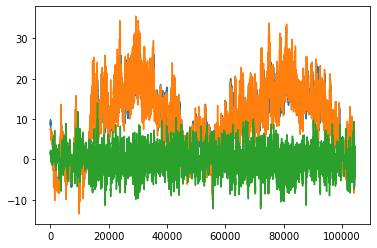

In [31]:
fig, ax = plt.subplots()
ax.plot(preds)
ax.plot(val_targets)
ax.plot(preds.ravel() - val_targets)

In [29]:
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 14), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [13]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length,
            output_dim = output_dim,
        )
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "input_dim": self.input_dim,
            "sequence_length": self.sequence_length
        })
        return config

    def call(self, inputs):
        length = self.sequence_length
        positions = tf.range(length)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

In [39]:
inputs = keras.Input(shape=(SEQUENCE_LENGTH, raw_data.shape[-1]))
# x = inputs
x = PositionalEmbedding(SEQUENCE_LENGTH, raw_data.shape[-1], raw_data.shape[-1])(inputs)
x = layers.MultiHeadAttention(num_heads = 4,key_dim=14)(x,x,x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_attention.keras", save_best_only=True, monitor="val_mae", mode="min", custom_objects=smape)]

model.compile(optimizer="adam", loss="mse", metrics=["mae",smape])

In [40]:
history = model.fit(train_dataset, epochs=5, validation_data = val_dataset, callbacks=callbacks)

Epoch 1/5
819/819 [==============================] - 7s 8ms/step - loss: 14.6511 - mae: 2.9185 - smape: 73.8451 - val_loss: 10.4274 - val_mae: 2.5233 - val_smape: 77.5735
Epoch 2/5
819/819 [==============================] - 6s 8ms/step - loss: 8.4769 - mae: 2.2944 - smape: 78.8371 - val_loss: 11.5768 - val_mae: 2.6480 - val_smape: 77.1074
Epoch 3/5
819/819 [==============================] - 6s 8ms/step - loss: 7.2669 - mae: 2.1266 - smape: 79.8814 - val_loss: 13.0896 - val_mae: 2.8112 - val_smape: 76.2264
Epoch 4/5
819/819 [==============================] - 6s 8ms/step - loss: 6.2979 - mae: 1.9763 - smape: 80.9436 - val_loss: 14.6233 - val_mae: 2.9579 - val_smape: 75.5331
Epoch 5/5
819/819 [==============================] - 6s 8ms/step - loss: 5.5283 - mae: 1.8468 - smape: 82.0000 - val_loss: 14.5434 - val_mae: 2.9703 - val_smape: 75.3342


In [32]:
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 120, 14)]    0           []                               
                                                                                                  
 positional_embedding_4 (Positi  (None, 120, 14)     1680        ['input_6[0][0]']                
 onalEmbedding)                                                                                   
                                                                                                  
 multi_head_attention_3 (MultiH  (None, 120, 14)     9926        ['positional_embedding_4[0][0]', 
 eadAttention)                                                    'positional_embedding_4[0][0]', 
                                                                  'positional_embedding_4[0]

In [26]:
model.layers[1](tf.zeros([120,14],tf.float32))[:,0]

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([-0.16764055, -0.09670158,  0.08995424, -0.33347857,  0.31676334,
       -0.17015515, -0.1498167 ,  0.287539  ,  0.28816718,  0.22321692,
       -0.03605475, -0.15735212,  0.1949494 , -0.44253668,  0.06794555,
        0.07532427, -0.33978343, -0.06304431,  0.15539218,  0.2356831 ,
        0.16678336,  0.15416257, -0.0321166 ,  0.24108188,  0.24669348,
        0.10867202,  0.3230525 , -0.12928565, -0.2655774 ,  0.07165019,
       -0.39238873, -0.0032194 ,  0.06168983, -0.11586176, -0.29833585,
       -0.16786477, -0.04552752, -0.1236538 , -0.05928417,  0.14452629,
       -0.14917527, -0.12082296, -0.19721213, -0.15511839,  0.03871487,
       -0.029557  , -0.02053608, -0.26046857, -0.01120455,  0.01382325,
       -0.35088176, -0.36499164, -0.4143581 , -0.35294628, -0.49539933,
       -0.20533396, -0.49818838, -0.12047103,  0.1583898 , -0.36805862,
       -0.35336146, -0.34597772, -0.3652212 ,  0.19483694, -0.27486354,
       -0.388791

In [25]:
model.layers[1](tf.zeros([120,14],tf.float32))[:,1]

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([-0.10108494, -0.21365573, -0.09131879, -0.05537372, -0.01629498,
       -0.01339414, -0.11822281, -0.04174552, -0.4705285 ,  0.21438323,
        0.1748464 , -0.32739544,  0.21960603, -0.0728462 ,  0.33066055,
        0.16350396, -0.06015201, -0.02301909, -0.14282364, -0.25874615,
       -0.11964386, -0.05253516, -0.05558702, -0.03880359, -0.1061    ,
       -0.04317635,  0.2273505 ,  0.22787188,  0.18826689,  0.53822434,
        0.31127968,  0.36931437,  0.31016922,  0.18049411,  0.07195791,
        0.2173784 ,  0.30984595, -0.11857644,  0.18500587,  0.11716499,
       -0.14615235,  0.3816058 ,  0.0720528 , -0.19492765,  0.1579155 ,
       -0.3434261 ,  0.06141305, -0.07161469,  0.01051698, -0.072308  ,
       -0.01263181, -0.32798696,  0.09436457,  0.03354817, -0.05803758,
        0.05639657, -0.003421  ,  0.22831815,  0.20350689,  0.00185803,
       -0.03837206, -0.19958259, -0.05589554, -0.01473013, -0.06181144,
       -0.411610

In [37]:
model = keras.models.load_model('jena_attention.keras', custom_objects={"smape":smape, "PositionalEmbedding": PositionalEmbedding})
preds = model.predict(val_dataset)
val_targets = []
for _, targets in val_dataset:
    val_targets.append(targets)
val_targets = np.concatenate(val_targets)

408/408 [==============================] - 2s 4ms/step


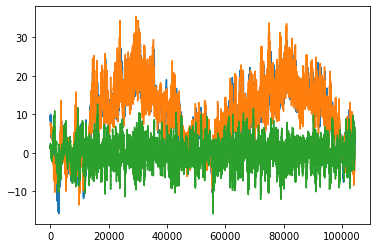

In [38]:
fig, ax = plt.subplots()
ax.plot(preds)
ax.plot(val_targets)
ax.plot(preds.ravel() - val_targets)